In [1]:
import pandas as pd
import numpy as np

In [2]:
def load(file):
    """Load the experiment data from a CSV file"""
    
    schema = {
        'First': np.int64(),
        'Last': np.int64(),
        'Parse': np.float64(),
        'Resize': np.float64(),
        'Serialize': np.float64(),
        'Pop': np.float64(),
    }
    
    df = pd.read_csv(file, dtype=schema)
    df.file = file

    return df

In [3]:
import os

def get_meta(path):
    """Returns (threads, num_jsons, repeats)"""
    props = os.path.splitext(os.path.basename(file))[0].split('_')
    return (int(props[1][1:]), int(props[2][1:]), int(props[3][1:]))

def analyze(df):
    """Analyze the experiment data, deriving various metrics."""
    
    df['Total'] = df['Parse'] + df['Resize'] + df['Serialize'] + df['Pop']
    df.threads, df.jsons, df.repeats = get_meta(df.file)
        
    return df

In [4]:
def summarize(df):
    """Summarize the data from all threads into one row."""
    
    row = {'Threads': df.threads,
           'JSONs': df.jsons,
           'Parse': df['Parse'].mean(),
           'Resize': df['Resize'].mean(),
           'Serialize': df['Serialize'].mean(),
           'Pop': df['Pop'].mean(),
           'Total': df['Total'].mean()}
              
    return row;

In [5]:
import glob

csv_files = []
for file in glob.glob("../experiments/data/latency/threads/latency/*.csv"):
    csv_files.append(file)

records = []
for file in csv_files:
    records.append(summarize(analyze(load(file))))


,JSONs,Parse,Resize,Serialize,Pop,Total
Threads,,,,,,
1,1,8.846622e+04,153.125000,3099.078125,3031.953125,9.475038e+04
1,2,8.997514e+04,161.718750,3620.875000,2577.984375,9.633572e+04
1,4,9.078317e+04,147.968750,3248.609375,2350.953125,9.653070e+04
1,8,9.205562e+04,161.875000,3759.156250,3203.781250,9.918044e+04
1,16,9.546203e+04,186.250000,4174.671875,2688.953125,1.025119e+05
...,...,...,...,...,...,...
16,32768,2.688860e+06,4591.262695,17539.189453,62755.235840,2.773746e+06
16,65536,5.094717e+06,7780.341797,34035.436523,97202.956543,5.233736e+06
16,131072,9.888415e+06,14967.259766,88413.094727,269087.879395,1.026088e+07


<ipython-input-6-f185e994e1b6>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-6-f185e994e1b6>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-6-f185e994e1b6>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-6-f185e994e1b6>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-6-f185e994e1b6>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-6-f185e994e1b6>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-6-f185e994e1b6>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)
<ipython-input-6-f185e994e1

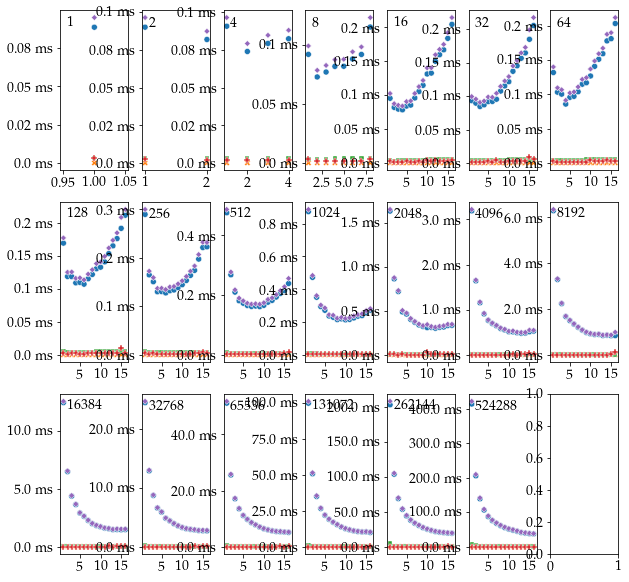

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pint

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})
    
df = pd.DataFrame.from_records(records).sort_values(by=['Threads', 'JSONs']).set_index('Threads')

display(df)

num_jsons = df.JSONs.unique()
num_jsons.sort()

rows = 3
cols = int(math.ceil(len(num_jsons)/rows))

ymax = df['Total'].max()

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=[10, 10])

for i, n in enumerate(num_jsons):
    units = pint.UnitRegistry()
    row = int(i / cols)
    col = i % cols
    ax = axs[row][col]
        
    subdf = df[df.JSONs == n]
    del subdf['JSONs']
    sns.scatterplot(ax=ax, data=subdf, legend=None)
    #axs[row][col].set_ylim([1e2, ymax])
    #axs[row][col].set_yscale('log')
    ax.annotate(str(n), xycoords='axes fraction', xy=(0.1, 0.9))
    labels = ['${:~L}$'.format(x) for x in (np.around(ax.get_yticks() * 1e-6, 2) * units.milliseconds)]
    ax.set_yticklabels(labels)
    ax.set_xlabel(None)

#fig.tight_layout()

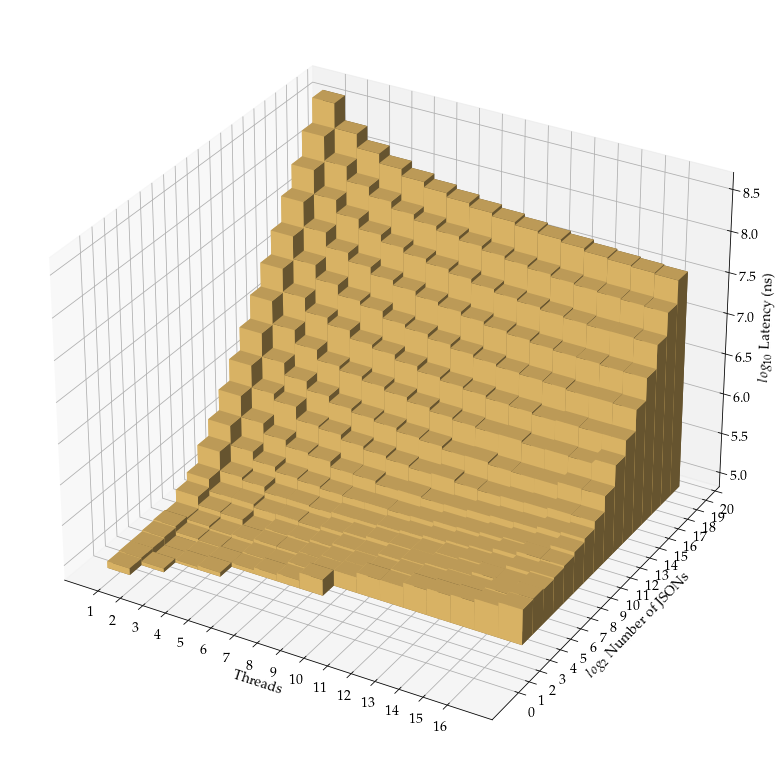

In [103]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(14, 14))

threads = df.index.unique().to_numpy()
jsons = df.JSONs.unique()

df2 = df.reset_index()
df2 = df2.set_index(['Threads', 'JSONs'])

xs = df.index.to_numpy()
ys = np.log2(df.JSONs.to_numpy())
zs = np.log10(df.Total.to_numpy())

bottom = zs.min()
top = zs.max()

ax.bar3d(x=xs-0.33, y=ys-1, z=bottom, dx=1, dy=1, dz=zs-bottom, color='#f5c971', alpha=1)

ax.set_zlim(bottom, top)
ax.set_xticks(range(1,17))
ax.set_yticks(range(0, 21, 1))

ax.set_ylabel('$log_{2}$ Number of JSONs')
ax.set_xlabel('Threads')
ax.set_zlabel('$log_{10}$ Latency (ns)')


plt.show()